In [358]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import optic.dsp as optic

In [110]:
def pnorm(sinal):
    return sinal/np.sqrt(np.sum((np.abs(sinal)**2))/len(sinal) )

def PAM(M,bits):
    try:
        isinstance(len(bits)/np.log2(M), int)
    except:
        print('Numero de bits não consegue ser mapeado por inteiro: Nbits/log2(M) deve ser inteiro')
    simbolos = pnorm(np.arange(M))
    modulado = np.zeros(int(len(bits)/np.log2(M)))
    bits = np.array(bits)
    bits = bits.astype(str)
    for i in range(int(len(bits)/np.log2(M))):
        modulado[i] = simbolos[int(''.join(bits[i*int(np.log2(M)):i*int(np.log2(M))+int(np.log2(M))]),2)]
    return modulado

def upsample(sinal,SpS):
    resultado = np.zeros(len(sinal)*SpS)
    for i in range(len(sinal)):
        resultado[i*SpS] = sinal[i]
    return resultado

# 11.1 e 11.2

C:\Users\lucas\AppData\Local\Temp\ipykernel_28812\2980587348.py:29: RuntimeWarning: divide by zero encountered in log10
  response = 10*np.log10(np.abs((A/abs(A).max())))


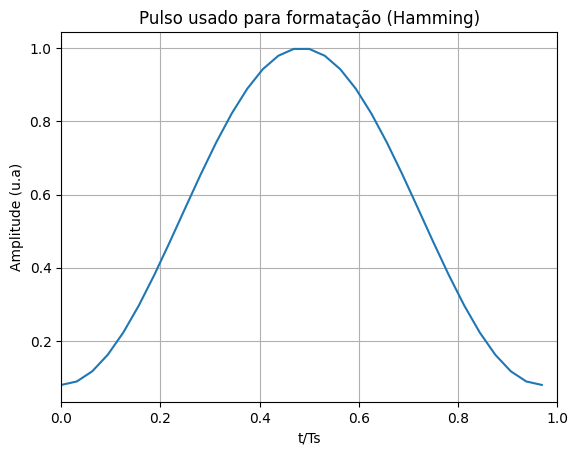

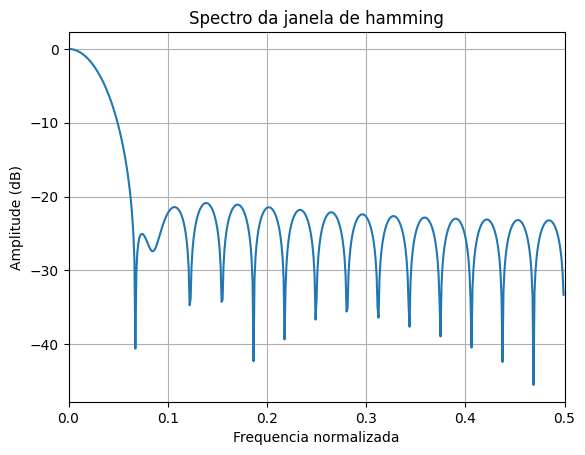

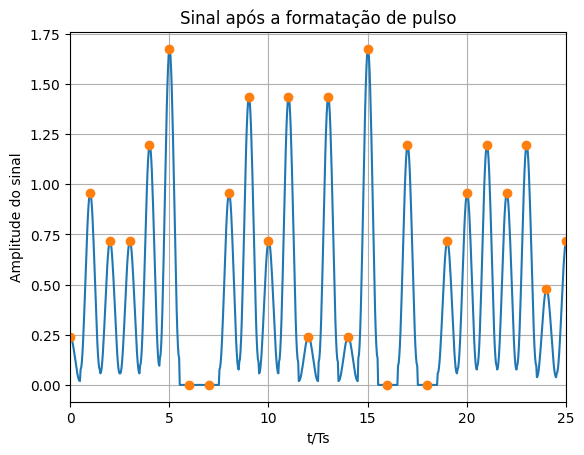

In [360]:
Nsimbolos = 1000
SpS = 32

M = 8
ISI = 1
# Geração e mapeamento dos bits
bits = np.random.randint(0,2,int(Nsimbolos*np.log2(M)))
simbolos = PAM(M,bits)
original = simbolos

# Upsampling
simbolos = upsample(simbolos,SpS)

# Formatação de pulso
janela = np.hamming(SpS*ISI)
sinal = optic.firFilter(janela,simbolos)

plt.figure(1)
plt.plot(np.arange(len(janela))/SpS,janela)
plt.xlim(0,len(janela)/SpS)
plt.grid()
plt.ylabel('Amplitude (u.a)')
plt.xlabel('t/Ts')
plt.title('Pulso usado para formatação (Hamming)')

plt.figure(2)
A = np.fft.fft(janela,n=1024)
freq = np.fft.fftfreq(len(A))
response = 10*np.log10(np.abs((A/abs(A).max())))
plt.plot(freq, response)
plt.xlim(0,0.5)
#plt.ylim(-60,0)
plt.xlabel("Frequencia normalizada")
plt.ylabel("Amplitude (dB)")
plt.title("Spectro da janela de hamming")
plt.grid()

plt.figure(3)
plt.plot(np.linspace(0,Nsimbolos,len(sinal)),sinal)
plt.plot(original,'o')
plt.xlim(0,25)
plt.xlabel('t/Ts')
plt.ylabel('Amplitude do sinal')
plt.title('Sinal após a formatação de pulso')
plt.grid()


# 11.14

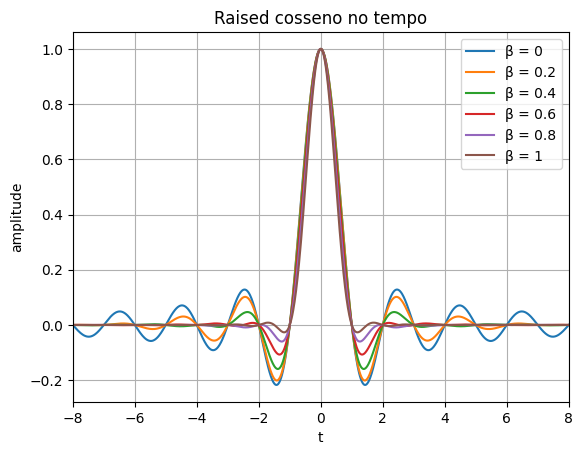

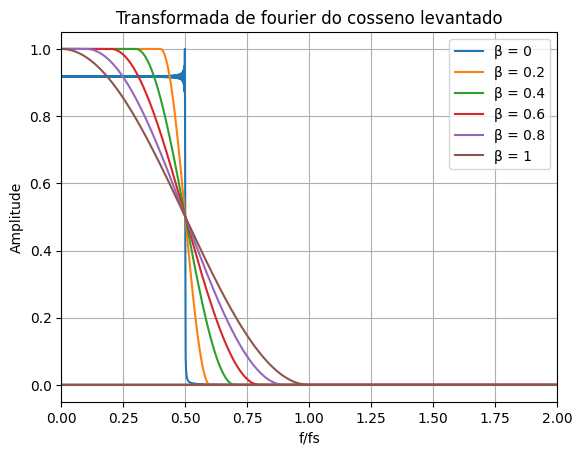

In [327]:
def rcosfilter(N, β, Ts, SpS):
    # N: Numero de amostras do filtro
    # β: roll-off
    # Ts: Periodo de simbolo
    # SpS: amostras por simbolo
    Fs = SpS*(1/Ts)
    Td = 1/(Fs)
    time = ((np.arange(N)-N/2))*Td
    janela = np.zeros(N, dtype=float)
    for x in np.arange(N):
        t = (x-N/2)*Td
        if t == 0.0:
            janela[x] = 1.0
            
        elif β != 0 and t == Ts/(2*β):
            janela[x] = (np.pi/4)*(np.sin(np.pi*t/Ts)/(np.pi*t/Ts))
            
        elif β != 0 and t == -Ts/(2*β):
            janela[x] = (np.pi/4)*(np.sin(np.pi*t/Ts)/(np.pi*t/Ts))
        else:
            janela[x] = (np.sin(np.pi*t/Ts)/(np.pi*t/Ts))* \
                    (np.cos(np.pi*β*t/Ts)/(1-(((2*β*t)/Ts)*((2*β*t)/Ts))))
    return time, janela

Ts = 1
SpS = 64
N = 2048*20
β = [0,0.2,0.4,0.6,0.8,1]

for i in β:
    time, janela = rcosfilter(N, i, Ts, SpS)
    plt.figure(1)
    plt.plot(time,janela,label = 'β = {}'.format(i))
    plt.figure(2)
    A = np.fft.fft(janela)
    freq = np.fft.fftfreq(len(A),1/(SpS*(1/Ts)))
    response =(np.abs((A/abs(A).max())))
    plt.plot(freq, response,label = 'β = {}'.format(i))
plt.figure(1)
plt.xlim(-8,8)
plt.grid()
plt.legend()
plt.title('Raised cosseno no tempo')
plt.xlabel('t')
plt.ylabel('amplitude')

plt.figure(2)
plt.xlim(0,2)
plt.xlabel('f/fs')
plt.ylabel('Amplitude')
plt.title('Transformada de fourier do cosseno levantado')
plt.legend()
plt.grid()

# 11.15

Diferente do caso de uma sinc, com o cosseno levantado é geralmente mais dificil dizer exatamente onde esta o momento ideal para amostrar o sinal

C:\Users\lucas\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


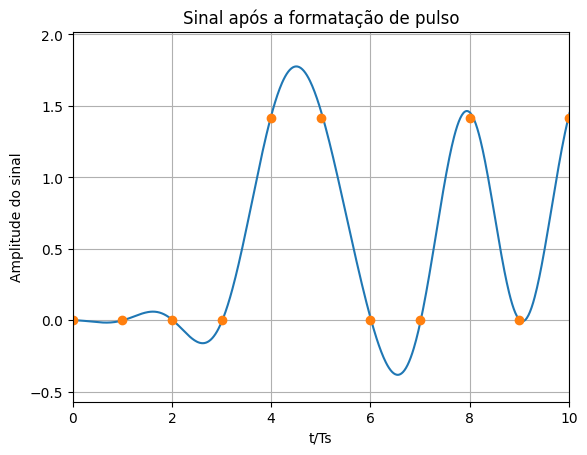

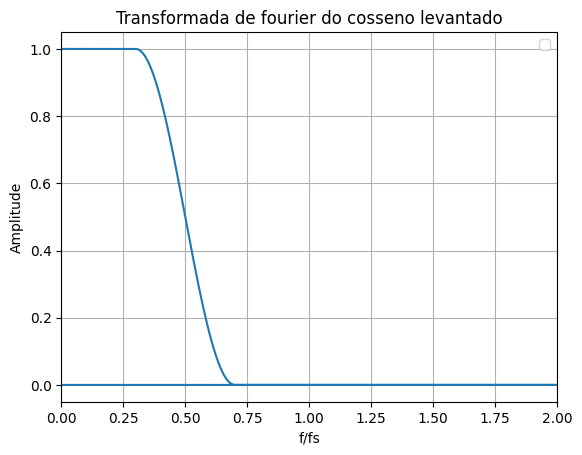

In [377]:
Nsimbolos = 1000
SpS = 64
M = 2
β = 0.4
Ntaps = 1024*20
Ts = 1
# Geração e mapeamento dos bits
bits = np.random.randint(0,2,int(Nsimbolos*np.log2(M)))
simbolos = PAM(M,bits)
original = simbolos


# Upsampling
simbolos = optic.upsample(simbolos,SpS) 
time, janela = rcosfilter(Ntaps, β, Ts, SpS)
sinal = pnorm(optic.firFilter(janela,simbolos))


plt.figure(2)
plt.plot(np.arange(len(sinal))*Ts/SpS,sinal)
plt.plot(original,'o')
plt.xlim(0,10)
plt.xlabel('t/Ts')
plt.ylabel('Amplitude do sinal')
plt.title('Sinal após a formatação de pulso')
plt.grid()
plt.figure(3)

A = np.fft.fft(janela)
freq = np.fft.fftfreq(len(A),1/(SpS*(1/Ts)))
response =(np.abs((A/abs(A).max())))
plt.plot(freq, response)
plt.xlim(0,2)
plt.xlabel('f/fs')
plt.ylabel('Amplitude')
plt.title('Transformada de fourier do cosseno levantado')
plt.legend()
plt.grid()